In [2]:
import pickle as pkl
import numpy as np
from itertools import chain

from src.models.train_emos import train_emos, train_and_test_emos
from src.visualization.pit import make_cpit_diagram_emos, make_cpit_hist_emos 
from src.visualization.brier_score import make_brier_skill_plot, brier_plot
from src.models.get_data import get_tensors, get_normalized_tensor
from src.models.emos import EMOS
from src.visualization.scoring_tables import make_table
from src.visualization.twcrpss_plot import make_twcrpss_plot
from src.models.emos import EMOS
from src.visualization.reliability_diagram import make_reliability_diagram, make_reliability_diagram_sklearn, make_reliability_and_sharpness
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_cdf, plot_forecast_pdf

Loading the TN EMOS trained on CRPS

In [3]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/emos/'

tn = load_model(folder + 'trunc_normal/tn_crps_.pkl')
print(tn)

Using given parameters for Truncated Normal distribution
EMOS Model Information:
Loss function: loss_CRPS_sample (Samples: 200)
Forecast distribution: distr_trunc_normal
Parameters:
  a_tn: [0.3965224]
  b_tn: [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
  c_tn: [1.5007248]
  d_tn: [1.0637333]
Features: wind_speed, press, kinetic, humid, geopot
Number of features: 5
Neighbourhood size: 11

Optimizer: Adam
Learning rate: 0.009999999776482582



In [4]:
print("The features we use are: ", tn.feature_names)

grid_size = tn.neighbourhood_size

print("The grid size to estimate the variance is: {}x{}".format(grid_size, grid_size))

The features we use are:  ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']
The grid size to estimate the variance is: 11x11


Loading the validation set

In [5]:
test_fold = 3
ignore = ['229', '285', '323']
X_test, y_test, variances_test = get_tensors(tn.neighbourhood_size, tn.feature_names, test_fold, ignore)
X_test = (X_test - tn.feature_mean) / tn.feature_std

print(X_test.shape)

(7780, 5)


In [6]:
y_list = y_test.numpy()
print("Size of the dataset: ", len(y_list))
print("The 95'th quantile of the validation set is: ", np.quantile(y_list, 0.95))
print("The 99'th quantile of the validation set is: ", np.quantile(y_list, 0.99))

print("Number of observations greater than 17: " , np.sum(y_list > 17))

Size of the dataset:  7780
The 95'th quantile of the validation set is:  12.210000038146973
The 99'th quantile of the validation set is:  15.4399995803833
Number of observations greater than 17:  31


Loading the TN models trained on different weight functions

In [6]:
tn_folder = folder + 'trunc_normal/'

tn_T12 = load_model(tn_folder +'tn_twcrps_threshold12.0.pkl')
tn_T15 = load_model(tn_folder +'tn_twcrps_threshold15.0.pkl')

tn_I_dict = {'tn_T12': tn_T12, 'tn_T15': tn_T15}



Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [7]:
tn_M12_STD4 = load_model(tn_folder + 'tn_twcrps_mean12.0_std4.0.pkl')
tn_M12_STD1 = load_model(tn_folder + 'tn_twcrps_mean12.0_std1.0.pkl')
tn_M15_STD1 = load_model(tn_folder + 'tn_twcrps_mean15.0_std1.0.pkl')
tn_M16_STD5 = load_model(tn_folder + 'tn_twcrps_mean16.0_std5.0.pkl')

tn_CDF_dict = {'tn_M12_STD4': tn_M12_STD4, 'tn_M12_STD1': tn_M12_STD1, 'tn_M15_STD1': tn_M15_STD1, 'tn_M16_STD5': tn_M16_STD5}

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


A comparison between the 'standard' truncated normal distribution (which is trained on the CRPS) and the models trained on different scoring rules. As weighted scoring rule the twCRPS is used with different weight functions. 

Possible weight functions:
- the indicator function with a specified threshold (T)
- the CDF of a normal distribution with specified mean and variance (M, STD)

In [8]:
tn_dict = {**tn_I_dict, **tn_CDF_dict}
sample_size = 2000
print("CRPS score for truncated normal: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

for key, model in tn_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

CRPS score for truncated normal:  0.890489
tn_T12 CRPS score:  0.9144188
tn_T15 CRPS score:  0.9102627
tn_M12_STD4 CRPS score:  0.898442
tn_M12_STD1 CRPS score:  0.91512907
tn_M15_STD1 CRPS score:  0.9099662
tn_M16_STD5 CRPS score:  0.90028733


There are 848 values in the PIT diagram


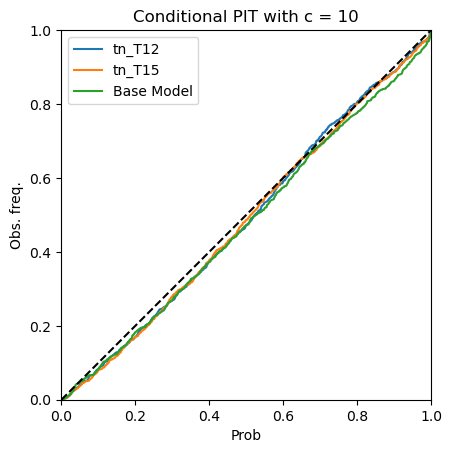

There are 848 values in the PIT diagram


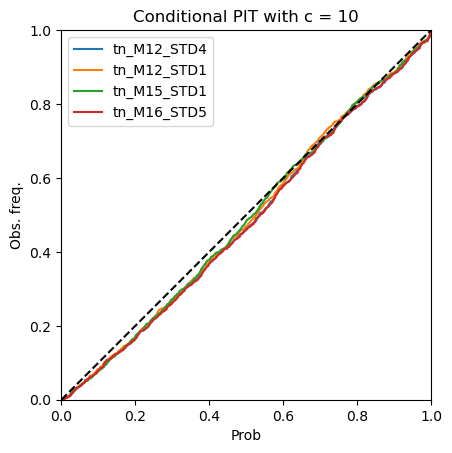

In [9]:
c = 10
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(tn_I_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(tn_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

<font size="5"> Brier skill scores for the different models. As reference model the 'standard' truncated normal distribution is used.</font>

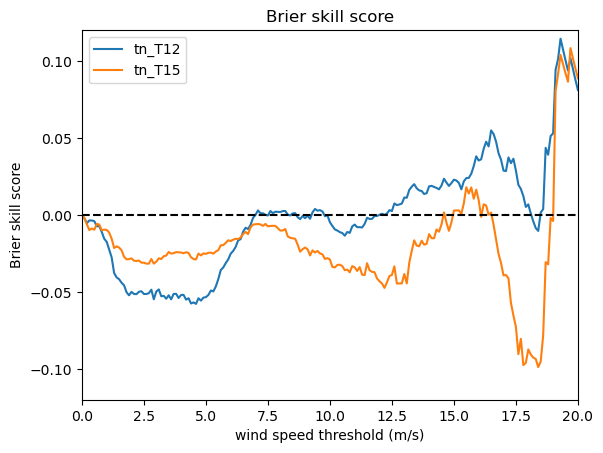

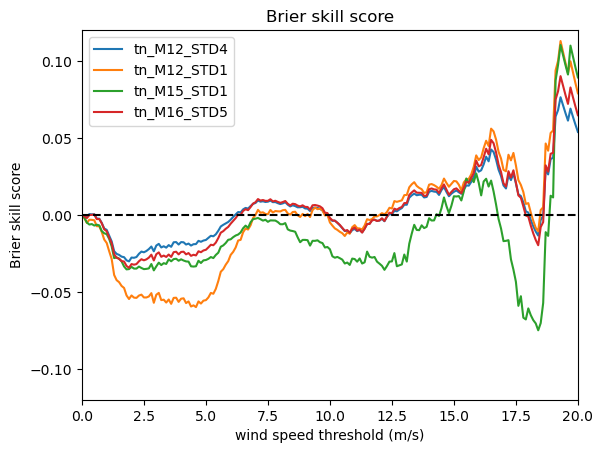

In [9]:
values = np.linspace(0, 20, 201)
ylim = [-0.12, 0.12]
brier_skill_plot(tn, tn_I_dict, X_test, y_test, variances_test, values, ylim=ylim)
brier_skill_plot(tn, tn_CDF_dict, X_test, y_test, variances_test, values, ylim=ylim)

<font size="5"> Threshold weighted continuously ranked probability scores for different threshold..</font>

Behavior of the twCRPSS above 17 gets pretty chaotic, since there are just 31 observations greater than 17. Means that including/exlcuding one of these observations can have a big impact on the twCRPSS

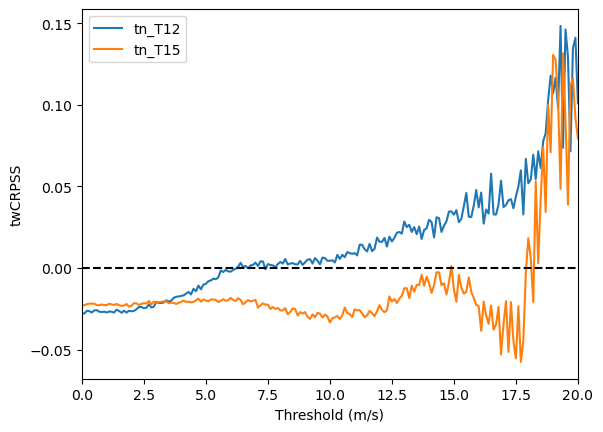

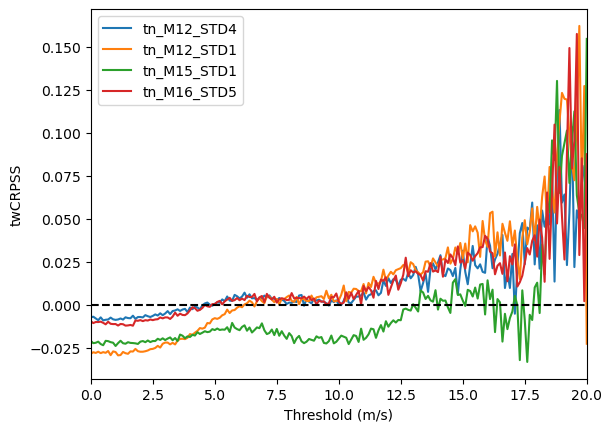

In [10]:
make_twcrpss_plot(tn, tn_I_dict, X_test, y_test, variances_test, values)
make_twcrpss_plot(tn, tn_CDF_dict, X_test, y_test, variances_test, values)

<font size="5"> Reliability diagrams for the models.</front>

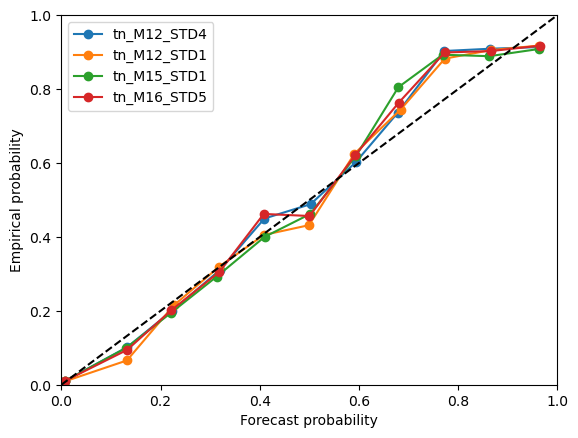

In [16]:
t = 10
make_reliability_diagram_sklearn(tn_CDF_dict, X_test, y_test, variances_test, t, 11)
#make_reliability_diagram(tn_CDF_dict, X_test, y_test, variances_test, t=t)

In most cases, the truncated normal EMOS model trained on the CRPS has the lowest variances, while the models trained on weighted scoring rules have a larger variance.

In [9]:
observation_value = 14
plot_size = 5
plot_forecast_pdf(tn_CDF_dict, X_test, y_test, variances_test, observation_value=observation_value, plot_size=plot_size, base_model=tn, seed=None)

InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [500] vs. [7780] [Op:Sub] name: 

In [43]:
params_base_model = tn.get_parameters()
print("The parameters of the base model are:")
for key, value in params_base_model.items():
    print(key, value)


The parameters of the base model are:
a_tn [0.3965224]
b_tn [ 0.9656694  -0.01666058 -0.146118    0.03517735  0.00451683]
c_tn [1.5007248]
d_tn [1.0637333]


In [45]:
model_name = "tn_M12_STD4"
params_other_model = tn_dict[model_name].get_parameters()

print("The parameters of the model {} are:".format(model_name))
for key, value in params_other_model.items():
    print(key, value)

The parameters of the model tn_M12_STD4 are:
a_tn [0.6530319]
b_tn [ 0.92374665 -0.27314404 -0.11053478  0.02316788  0.33249754]
c_tn [2.143375]
d_tn [1.0531572]


<font size="5"> Loading the GEV models

In [13]:
gev_folder = folder + 'gev/'

gev = load_model(gev_folder + 'gev_crps_.pkl')

gev_T15 = load_model(gev_folder + 'gev_twcrps_threshold15.0.pkl')
gev_T12 = load_model(gev_folder + 'gev_twcrps_threshold12.0.pkl')

gev_M12_STD4 = load_model(gev_folder + 'gev_twcrps_mean12.0_std4.0.pkl')
gev_M12_STD1 = load_model(gev_folder + 'gev_twcrps_mean12.0_std1.0.pkl')
gev_M16_STD5 = load_model(gev_folder + 'gev_twcrps_mean16.0_std5.0.pkl')

gev_crps_dict = {'gev': gev}
gev_I_dict = {'gev_T12': gev_T12, 'gev_T15': gev_T15}
gev_CDF_dict = {'gev_M12_STD4': gev_M12_STD4, 'gev_M12_STD1': gev_M12_STD1, 'gev_M16_STD5': gev_M16_STD5}

gev_dict = {**gev_I_dict, **gev_CDF_dict, **gev_crps_dict}

Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution
Using given parameters for Generalized Extreme Value distribution


In [14]:
print("Truncated normal CRPS score: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())
for key, model in gev_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

Truncated normal CRPS score:  0.8902087


gev_T12 CRPS score:  1.2321391
gev_T15 CRPS score:  1.297275
gev_M12_STD4 CRPS score:  0.9013667
gev_M12_STD1 CRPS score:  1.1466995
gev_M16_STD5 CRPS score:  0.9055492
gev CRPS score:  0.8954328


In [15]:
for key, model in gev_dict.items():
    print(key, "Shape parameter: ", model.forecast_distribution.get_gev_shape())

gev_T12 Shape parameter:  [-0.26412857]
gev_T15 Shape parameter:  [-0.21399204]
gev_M12_STD4 Shape parameter:  [-0.22507769]
gev_M12_STD1 Shape parameter:  [-0.26842716]
gev_M16_STD5 Shape parameter:  [-0.23545313]
gev Shape parameter:  [-0.2308029]


There are 848 values in the PIT diagram


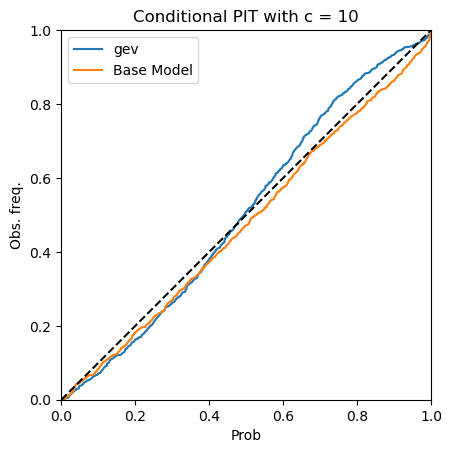

There are 848 values in the PIT diagram


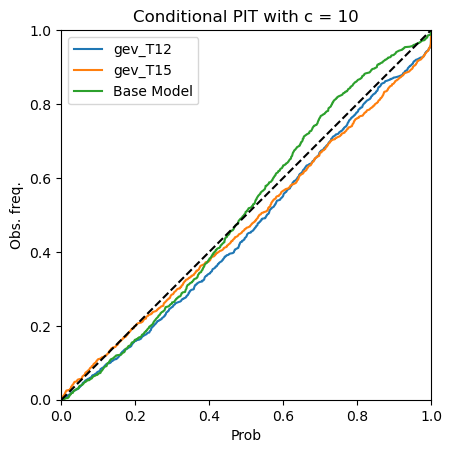

There are 848 values in the PIT diagram


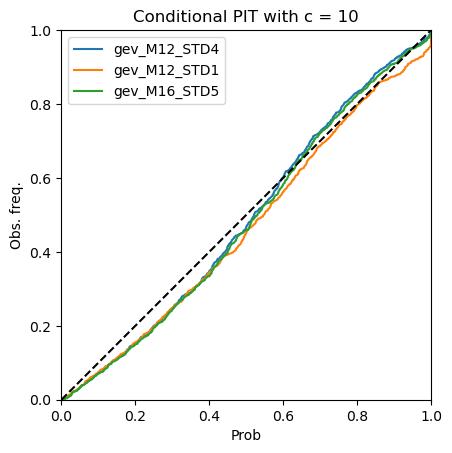

In [55]:
c = 10
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(gev_crps_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(gev_I_dict, X_test, y_test, variances_test, title=title, t=c, base_model=gev)
make_cpit_diagram_emos(gev_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

The models gev_T12 and gev_M12_STD1 large fall outside of the graph due to extremely poor performance.

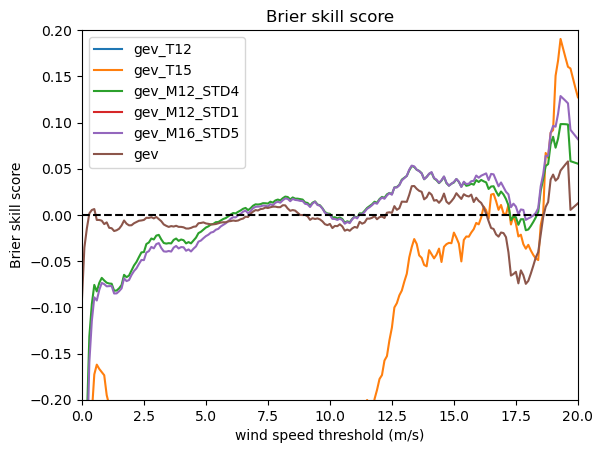

In [17]:
ylim = [-0.2, 0.2]
# ylim = None

brier_skill_plot(tn, gev_dict, X_test, y_test, variances_test, values, ylim=ylim)

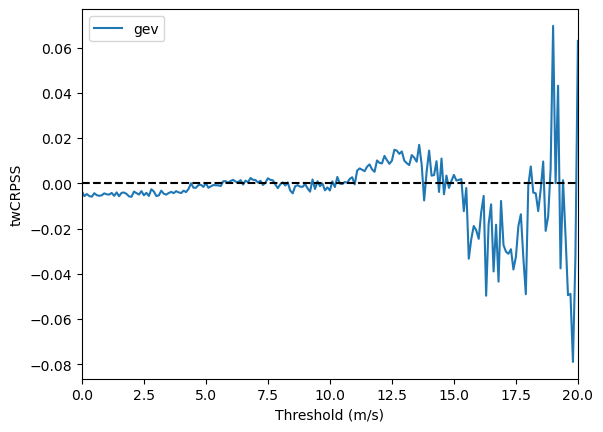

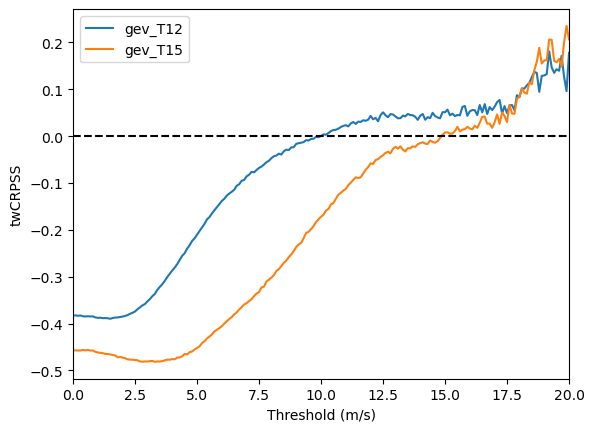

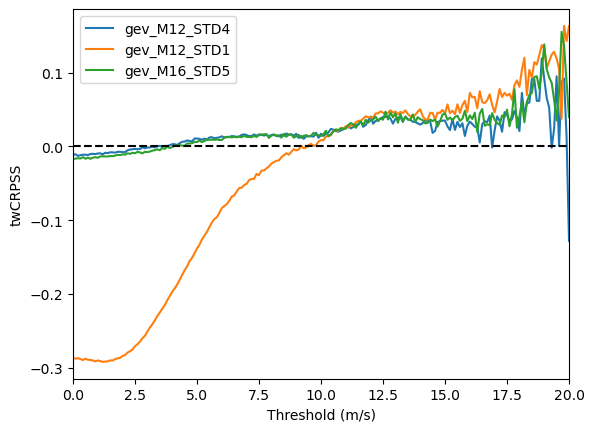

In [18]:
make_twcrpss_plot(tn, gev_crps_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, gev_I_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, gev_CDF_dict, X_test, y_test, variances_test, values, sample_size=1000)

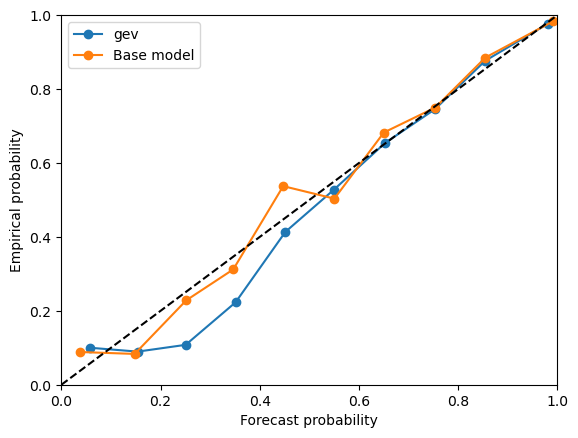

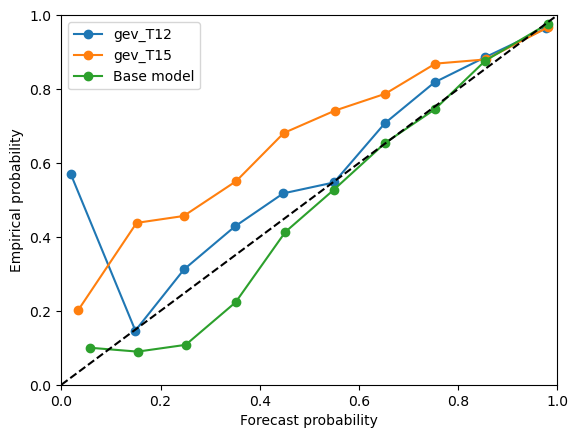

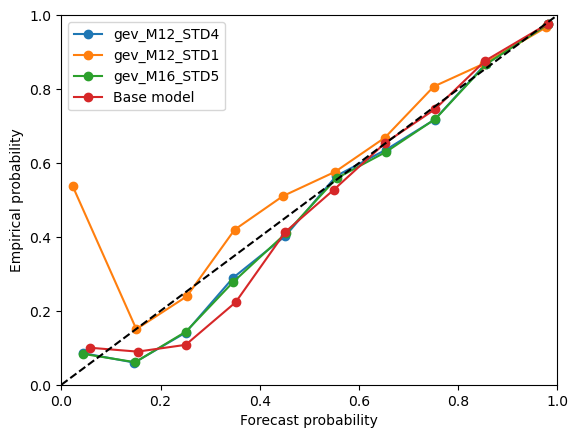

In [19]:
t = 10

make_reliability_diagram(gev_crps_dict, X_test, y_test, variances_test, t=t, base_model=tn)
make_reliability_diagram(gev_I_dict, X_test, y_test, variances_test, t=t, base_model=gev)
make_reliability_diagram(gev_CDF_dict, X_test, y_test, variances_test, t=t, base_model=gev)

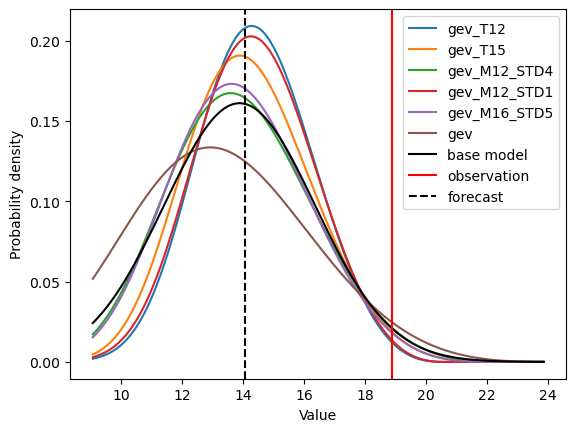

In [60]:
plot_size = 5
observation_value = 17
plot_forecast_pdf(gev_dict, X_test, y_test, variances_test, observation_value=observation_value, plot_size=plot_size, base_model=tn, seed=None)

<font size="5"> Frechet distribution

In [21]:
frechet_folder = folder + 'frechet/'

frechet = load_model(frechet_folder + 'frechet_crps_.pkl')

frechet_T15 = load_model(frechet_folder + 'frechet_twcrps_threshold15.0.pkl')
frechet_T12 = load_model(frechet_folder + 'frechet_twcrps_threshold12.0.pkl')

frechet_M12_STD4 = load_model(frechet_folder + 'frechet_twcrps_mean12.0_std4.0.pkl')
frechet_M12_STD1 = load_model(frechet_folder + 'frechet_twcrps_mean12.0_std1.0.pkl')
frechet_M16_STD5 = load_model(frechet_folder + 'frechet_twcrps_mean16.0_std5.0.pkl')

frechet_crps_dict = {'frechet': frechet}
frechet_I_dict = {'frechet_T12': frechet_T12, 'frechet_T15': frechet_T15}
frechet_CDF_dict = {'frechet_M12_STD4': frechet_M12_STD4, 'frechet_M12_STD1': frechet_M12_STD1, 'frechet_M16_STD5': frechet_M16_STD5}

frechet_dict = {**frechet_I_dict, **frechet_CDF_dict, **frechet_crps_dict}

Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution
Using given parameters for Frechet distribution


In [22]:
print("Truncated normal CRPS score: ", tn.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())
for key, model in frechet_dict.items():
    print(key, "CRPS score: ", model.loss_CRPS_sample_general(X_test, y_test, variances_test, sample_size).numpy())

Truncated normal CRPS score:  0.8903007


frechet_T12 CRPS score:  1.2901133
frechet_T15 CRPS score:  1.408956
frechet_M12_STD4 CRPS score:  0.9061805
frechet_M12_STD1 CRPS score:  1.1694895
frechet_M16_STD5 CRPS score:  0.9098101
frechet CRPS score:  0.8997343


There are 7780 values in the PIT diagram


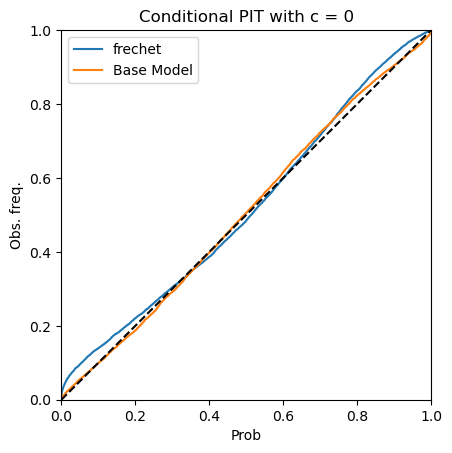

There are 7780 values in the PIT diagram


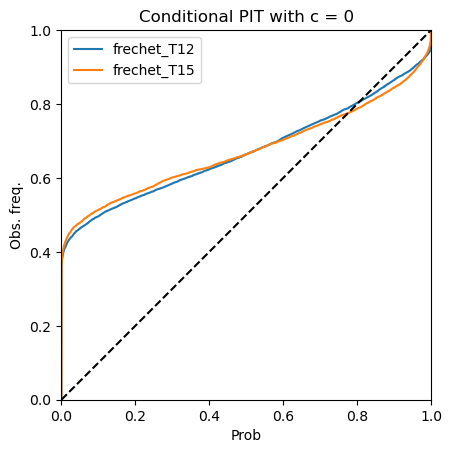

There are 7780 values in the PIT diagram


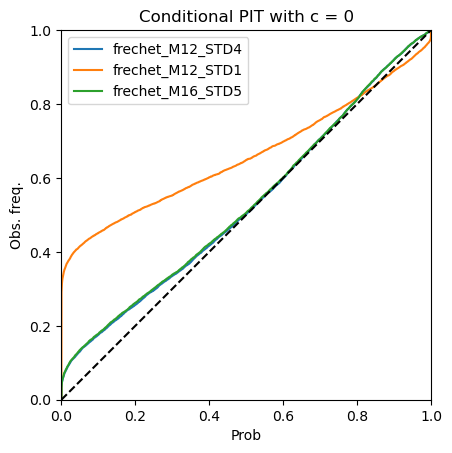

In [23]:
c = 0
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(frechet_crps_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn)
make_cpit_diagram_emos(frechet_I_dict, X_test, y_test, variances_test, title=title, t=c)
make_cpit_diagram_emos(frechet_CDF_dict, X_test, y_test, variances_test, title=title, t=c)

The frechet_T12, frechet_T15 and frechet_M12_STD1 largely fall out of the plot due to extremely poor performance 

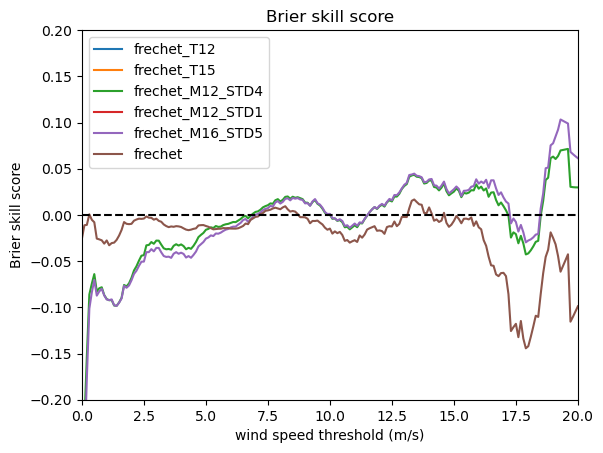

In [24]:
ylim = [-0.2, 0.2]
# ylim = None

brier_skill_plot(tn, frechet_dict, X_test, y_test, variances_test, values, ylim=ylim)

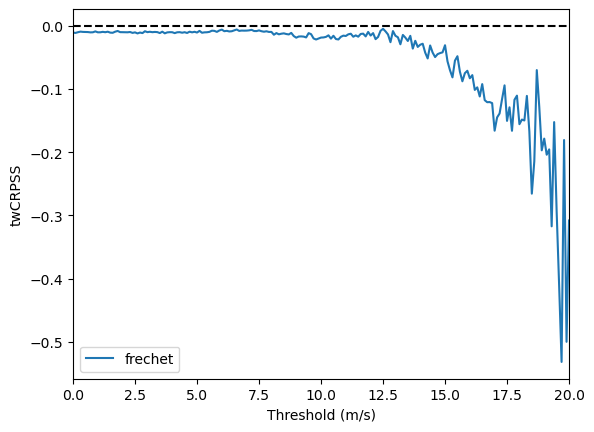

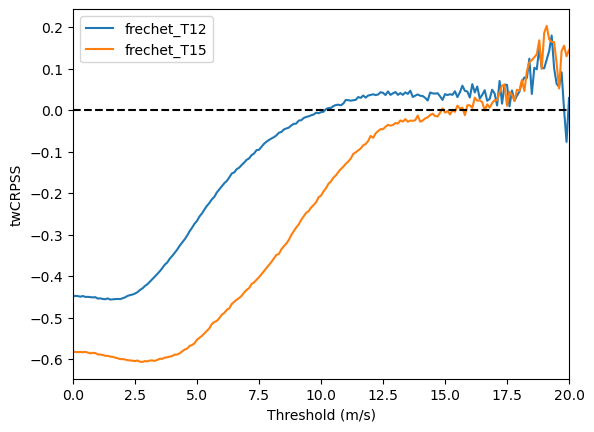

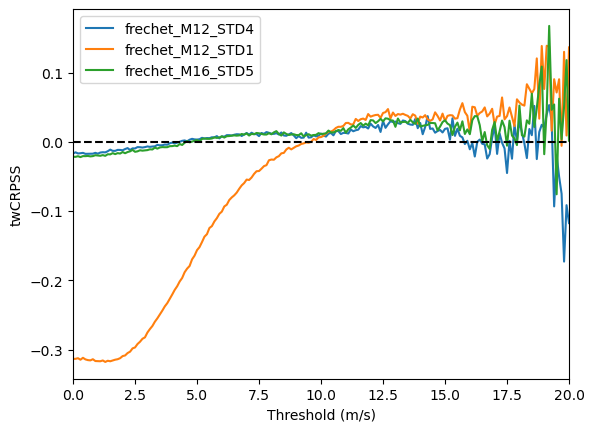

In [25]:
make_twcrpss_plot(tn, frechet_crps_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, frechet_I_dict, X_test, y_test, variances_test, values, sample_size=1000)
make_twcrpss_plot(tn, frechet_CDF_dict, X_test, y_test, variances_test, values, sample_size=1000)

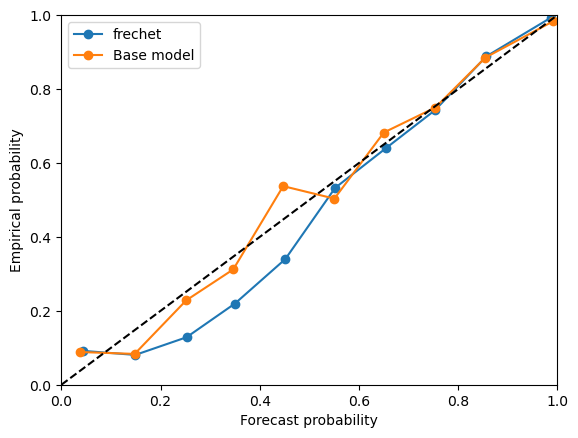

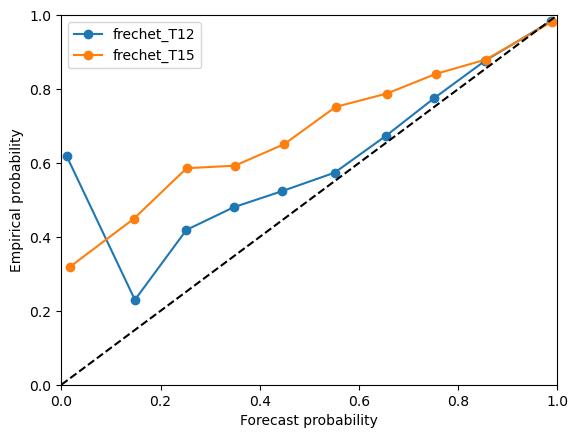

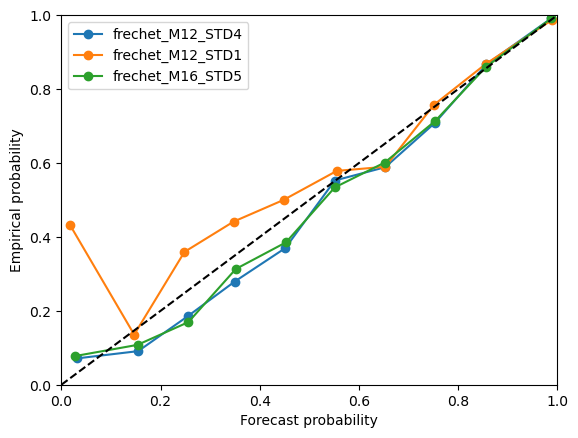

In [26]:
t = 10
make_reliability_diagram(frechet_crps_dict, X_test, y_test, variances_test, t=t, base_model=tn)
make_reliability_diagram(frechet_I_dict, X_test, y_test, variances_test, t=t)
make_reliability_diagram(frechet_CDF_dict, X_test, y_test, variances_test, t=t)

<font size="5">A comparison between models trained on the same (weighted) scoring rule with different probability distributions

We first consider the models trained of cdf of normal distribution with M=12, STD=4

In [27]:
cdf_M12_STD4_dict = {'tn_M12_STD4': tn_M12_STD4, 'gev_M12_STD4': gev_M12_STD4, 'frechet_M12_STD4': frechet_M12_STD4}
tn_M12_STD4 = cdf_M12_STD4_dict.pop('tn_M12_STD4')

In [28]:
print("Truncated normal twCRPS loss with M=12, STD=4: ", tn_M12_STD4.loss(X_test, y_test, variances_test).numpy())
for key, model in cdf_M12_STD4_dict.items():
    print(key, "twCRPS loss: ", model.loss(X_test, y_test, variances_test).numpy())

Truncated normal twCRPS loss with M=12, STD=4:  0.12268771
gev_M12_STD4 twCRPS loss:  0.12209436
frechet_M12_STD4 twCRPS loss:  0.12231961


There are 848 values in the PIT diagram


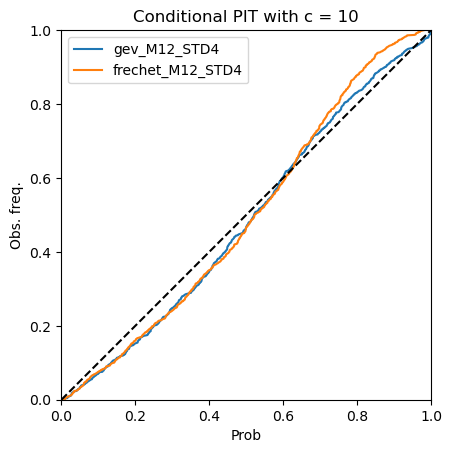

In [29]:
c = 10
title = "Conditional PIT with c = " + str(c)
make_cpit_diagram_emos(cdf_M12_STD4_dict, X_test, y_test, variances_test, title=title, t=c)

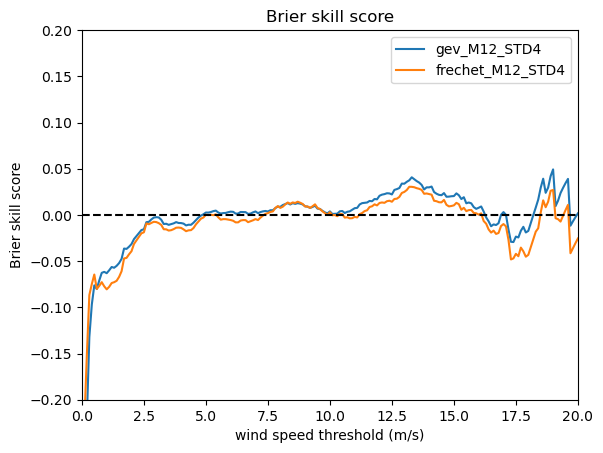

In [30]:
brier_skill_plot(tn_M12_STD4, cdf_M12_STD4_dict, X_test, y_test, variances_test, values, ylim=ylim)

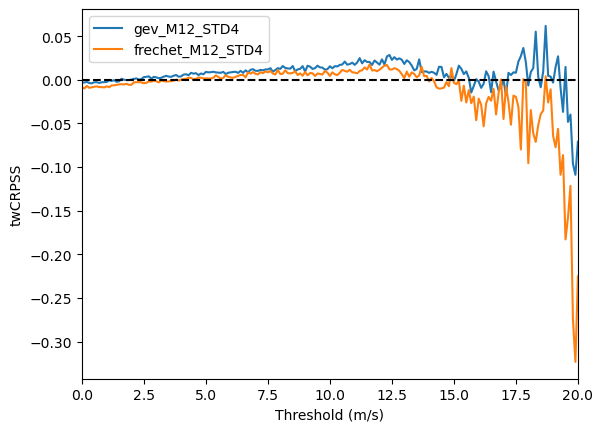

In [31]:
make_twcrpss_plot(tn_M12_STD4, cdf_M12_STD4_dict, X_test, y_test, variances_test, values, sample_size=1000)

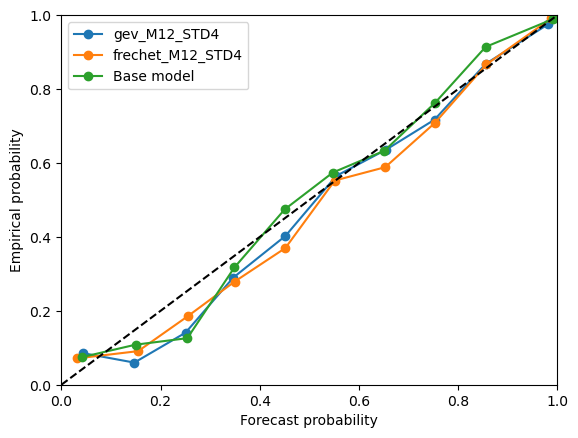

In [32]:
t = 10
make_reliability_diagram(cdf_M12_STD4_dict, X_test, y_test, variances_test, t=t, base_model=tn_M12_STD1)

In [33]:
cdf_M16_STD5_dict = {'tn_M16_STD5': tn_M16_STD5, 'gev_M16_STD5': gev_M16_STD5, 'frechet_M16_STD5': frechet_M16_STD5}

tn_M16_STD5 = cdf_M16_STD5_dict.pop('tn_M16_STD5')

In [34]:
print("Truncated normal twCRPS loss with M=16, STD=5: ", tn_M16_STD5.loss(X_test, y_test, variances_test).numpy())
for key, model in cdf_M16_STD5_dict.items():
    print(key, "twCRPS loss: ", model.loss(X_test, y_test, variances_test).numpy())

Truncated normal twCRPS loss with M=16, STD=5:  0.051556785
gev_M16_STD5 twCRPS loss:  0.051038265
frechet_M16_STD5 twCRPS loss:  0.051301453


There are 848 values in the PIT diagram


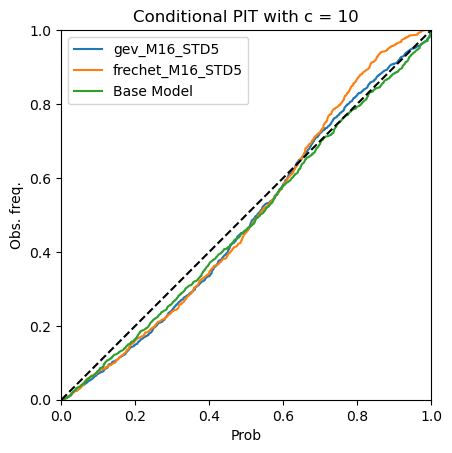

In [35]:
make_cpit_diagram_emos(cdf_M16_STD5_dict, X_test, y_test, variances_test, title=title, t=c, base_model=tn_M16_STD5)

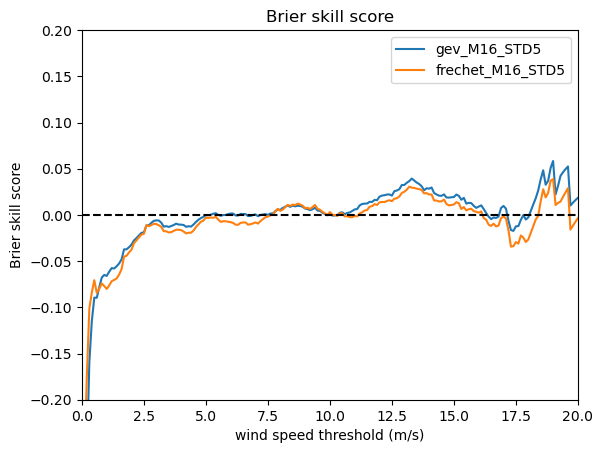

In [36]:
brier_skill_plot(tn_M16_STD5, cdf_M16_STD5_dict, X_test, y_test, variances_test, values, ylim=ylim)

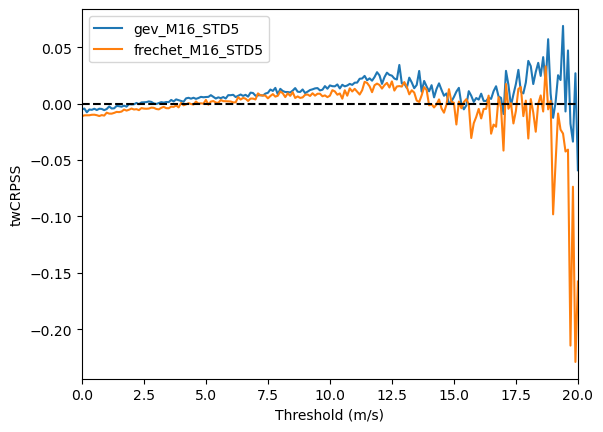

In [37]:
make_twcrpss_plot(tn_M16_STD5, cdf_M16_STD5_dict, X_test, y_test, variances_test, values, sample_size=1000)

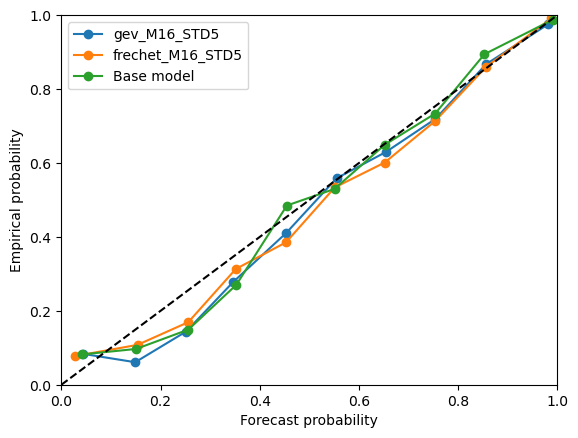

In [38]:
make_reliability_diagram(cdf_M16_STD5_dict, X_test, y_test, variances_test, t=t, base_model=tn_M16_STD5)